# Imports

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.random import normal, uniform
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import dill
import datetime

In [2]:
%matplotlib inline

In [3]:
SEED = 73 # random seed

In [ ]:
# dill.load_session('Full_NN.db')

In [ ]:
# dill.dump_session('Full_NN.db')

# Data reading

## Reading

In [64]:
targets = []

for name in gene_names:
    if not name.startswith('FT'):
        targets.append(name)

targets.sort()

targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [4]:
csvs = [x for x in os.listdir('data/') if x.endswith('.csv')] # читаем имена файлов .csv

In [5]:
needed_csvs = []

for s in csvs:
    if 'CDC' in s:
        needed_csvs.append(s)

In [6]:
nms = [x.split('.')[0] for x in needed_csvs] # список имён будущих датафреймов сделаем без расширений

In [7]:
nms

['AP1_CDCFrontier_LD',
 'AP1_CDCFrontier_SD',
 'FD_CDCFrontier_LD',
 'FD_CDCFrontier_SD',
 'FTa1_CDCFrontier_LD',
 'FTa1_CDCFrontier_SD',
 'FTa2_CDCFrontier_LD',
 'FTa2_CDCFrontier_SD',
 'FTa3_CDCFrontier_LD',
 'FTa3_CDCFrontier_SD',
 'FTb_CDCFrontier_LD',
 'FTb_CDCFrontier_SD',
 'FTc_CDCFrontier_LD',
 'FTc_CDCFrontier_SD',
 'LFY_CDCFrontier_LD',
 'LFY_CDCFrontier_SD',
 'TFL1a_CDCFrontier_LD',
 'TFL1a_CDCFrontier_SD',
 'TFL1c_CDCFrontier_LD',
 'TFL1c_CDCFrontier_SD']

In [8]:
for i in range(len(nms)):
    nms[i] = '_'.join(nms[i].split('_CDCFrontier_'))

In [9]:
nms

['AP1_LD',
 'AP1_SD',
 'FD_LD',
 'FD_SD',
 'FTa1_LD',
 'FTa1_SD',
 'FTa2_LD',
 'FTa2_SD',
 'FTa3_LD',
 'FTa3_SD',
 'FTb_LD',
 'FTb_SD',
 'FTc_LD',
 'FTc_SD',
 'LFY_LD',
 'LFY_SD',
 'TFL1a_LD',
 'TFL1a_SD',
 'TFL1c_LD',
 'TFL1c_SD']

In [10]:
data = {}
for i in range(len(nms)):
    data[nms[i]] = pd.read_csv('data/' + needed_csvs[i], header=None, names = ['days', 'rltv_transcription_lvl', 'std_error'])

In [11]:
print(len(data['FTa2_LD']))
print(len(data['FTa2_SD']))

15
14


In [13]:
data['TFL1c_SD']

,days,rltv_transcription_lvl,std_error
0,9,15.862,2.228863
1,11,14.804,2.726000
2,13,15.285,2.228863
3,15,19.238,3.165000
4,17,24.466,4.703000
5,19,25.650,2.154000
6,22,40.503,9.802000
7,25,15.267,2.228863
8,28,19.571,2.228863
9,31,22.599,2.228863


## Delete last

In [ ]:
plt.plot(data['AP1_SD'].days, data['AP1_SD'].rltv_transcription_lvl, 'o-');

In [ ]:
plt.plot(data['AP1_LD'].days, data['AP1_LD'].rltv_transcription_lvl, 'o-');

let's remove last measurements:

In [ ]:
for name in data.keys():
    if name.endswith('LD'):
        data[name] = data[name].iloc[:-1,:]
    else:
        data[name] = data[name].iloc[:-3,:]

In [ ]:
print(len(data['FTa2_LD']))
print(len(data['FTa2_SD']))

In [ ]:
plt.plot(data['AP1_SD'].days, data['AP1_SD'].rltv_transcription_lvl, 'o-');

In [ ]:
plt.plot(data['AP1_LD'].days, data['AP1_LD'].rltv_transcription_lvl, 'o-');

# Resampling

## Create samples base by days

In [ ]:
for i in data['AP1_LD']['days']:
    print(i, end=' ')

In [ ]:
samples_by_day = {}
for name in nms:
    samples_by_day[name] = {}

for name in nms:
    for i in range(len(data[name])):
        mean = data[name].iloc[i]['rltv_transcription_lvl']
        std = data[name].iloc[i]['std_error']
        samples_by_day[name][data[name].iloc[i]['days']] = normal(mean, std, 100)

## Create whole-time samples

In [ ]:
names = set(n[:-3] for n in nms)

Создадим два словаря (будущих датафрейма): ключ -- ген, значения -- уровень в определённый день.
Каждый будет содержать уровни экспрессий в определённый момент. Так как для SD 11 дней, а для LD 14, то один полный эксперимент для каждого гена составляет 25 наблюдений. Следовательно, возьмём 40 таких экспериментов, чтобы набрать 1000 наблюдений в общем.

In [ ]:
synth_LD = {}
synth_SD = {}

for name in names:
    synth_LD[name] = []
    synth_SD[name] = []



for j in range(40):
    for name in nms:
        whole_set = [] # искуственный эксперимент, охватывающий все дни
        days = list(samples_by_day[name].keys())
        
        # перебираем по дням, из каждого равновероятно берём значение:
        for day in days:
            whole_set.append(random.choice(samples_by_day[name][day]))
        
        # сдвиг на полдня вниз для FT генов:
        if name.startswith('FT'):
            FT_set = [whole_set[0]]
            for i in range(1, len(whole_set)):
                FT_set.append((whole_set[i-1] + whole_set[i]) / 2)
            whole_set = FT_set
        
        if name.endswith('LD'):
            for element in whole_set:
                synth_LD[name[:-3]].append(element)
        else:
            for element in whole_set:
                synth_SD[name[:-3]].append(element)

synth_LD = pd.DataFrame(synth_LD)
synth_SD = pd.DataFrame(synth_SD)

In [ ]:
synth_LD.tail()

In [ ]:
synth_SD['LD'] = 0
synth_LD['LD'] = 1

In [ ]:
synth_LD.head()

In [ ]:
data['FTa2_LD']

## Data joining

In [ ]:
tr_lvls_combined = pd.concat([synth_LD, synth_SD], ignore_index=True)

**пока что дропнем тип дня**

In [ ]:
tr_lvls_combined = tr_lvls_combined.drop('LD', axis = 1)

In [ ]:
tr_lvls_combined.head()

In [ ]:
tr_lvls_combined = tr_lvls_combined.reindex(sorted(tr_lvls_combined.columns), axis=1)

In [ ]:
tr_lvls_combined.head(1)

## Write prepared data to file for further usage

In [ ]:
tr_lvls_combined.to_csv('data/prepared/data_processed.csv', index=False)

# Real data tests

In [15]:
def logging(description, out):
    string = str(description) + ': ' + str(out)
    with open('results/NN/NN_log.txt', 'a') as out_file:
        out_file.write(string + '\n')
    print(string)

In [16]:
def clear_log():
    with open('results/NN/NN_log.txt', 'w') as out_file:
        out_file.write('log file have been cleared ' + str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))

In [17]:
with open('SVR_model2.cached', 'rb') as file:
    model = dill.load(file)

In [18]:
nms

['AP1_LD',
 'AP1_SD',
 'FD_LD',
 'FD_SD',
 'FTa1_LD',
 'FTa1_SD',
 'FTa2_LD',
 'FTa2_SD',
 'FTa3_LD',
 'FTa3_SD',
 'FTb_LD',
 'FTb_SD',
 'FTc_LD',
 'FTc_SD',
 'LFY_LD',
 'LFY_SD',
 'TFL1a_LD',
 'TFL1a_SD',
 'TFL1c_LD',
 'TFL1c_SD']

In [27]:
gene_names = []

for name in nms:
    gene_names.append(name[:-3])
    
gene_names = np.unique(gene_names)

In [28]:
gene_names

array(['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a',
       'TFL1c'], dtype='<U5')

In [21]:
true_lvls_SD = {}
true_lvls_LD = {}

In [22]:
for name in nms:
    if name.endswith('LD'):
        true_lvls_LD[name[:-3]] = data[name].rltv_transcription_lvl.values
    else:
        true_lvls_SD[name[:-3]] = data[name].rltv_transcription_lvl.values

true_lvls_LD = pd.DataFrame(true_lvls_LD)
true_lvls_SD = pd.DataFrame(true_lvls_SD)

In [23]:
true_lvls_LD

,AP1,FD,FTa1,FTa2,FTa3,FTb,FTc,LFY,TFL1a,TFL1c
0,2,31.53,2,8,0.9,3,0,6.4,22.021,25.556
1,0,47.62,0,11,0.5,7,0,12.1,20.489,25.263
2,6,45.41,1,29,0.8,6,0,21.4,27.397,32.982
3,5,40.89,5,60,10.2,28,0,56.8,33.074,39.708
4,23,79.47,9,50,1.3,12,0,77.1,42.561,32.222
5,33,71.69,40,86,2.5,58,0,48.9,54.798,67.895
6,1,25.86,10,18,3.4,7,0,16.0,8.314,11.930
7,92,43.31,10,68,4.7,127,0,45.1,18.325,25.731
8,19,45.20,10,37,2.1,61,0,27.7,15.851,18.713
9,355,81.78,6,52,14.8,102,14,50.9,22.232,29.766


In [31]:
with open('SVR_scalers2.cached', 'rb') as f:
    st_scalers = dill.load(f)

In [39]:
true_lvls_LD_st = pd.DataFrame(StandardScaler().fit_transform(true_lvls_LD), columns=gene_names)
true_lvls_SD_st = pd.DataFrame(StandardScaler().fit_transform(true_lvls_SD), columns=gene_names)

C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [42]:
predictions_LD = {}
predictions_SD = {}

In [43]:
for name in gene_names:
    predictions_LD[name] = model[name].predict(true_lvls_LD_st.drop(name, axis=1))
    predictions_SD[name] = model[name].predict(true_lvls_SD_st.drop(name, axis=1))

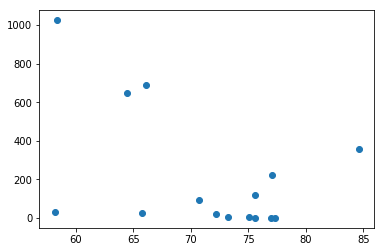

In [45]:
plt.plot(predictions_LD['AP1'], true_lvls_LD['AP1'], 'o')